In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    #plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

In [2]:
from sklearn.svm import SVC

In [3]:
landmarks = pd.read_csv('./data/tidyLandmarks.csv')
landmarks.head()

,Unnamed: 0,Index,min_alpha,max_alpha,min_theta,max_theta,num,pts,r,stype
0,1,1,-14.29,-4.76,-0.79,0.00,50,1251,5.000388,mt-zrf
1,2,1,-14.29,-4.76,-1.57,-0.79,50,313,2.442931,mt-zrf
2,3,1,-14.29,-4.76,-2.36,-1.57,50,30,1.475318,mt-zrf
3,4,1,-14.29,-4.76,-3.14,-2.36,50,169,1.438607,mt-zrf
4,5,1,-14.29,-4.76,0.00,0.79,50,773,3.382828,mt-zrf


## SVM Method 

In [8]:
def svm_classification(landmarks, min_alpha, max_alpha, min_theta, max_theta):
    # filter out the landmarks needed
    chosenLandmark = landmarks[np.logical_and(
        np.logical_and(landmarks.min_alpha==min_alpha, landmarks.max_alpha==max_alpha), 
        np.logical_and(landmarks.min_theta==min_theta, landmarks.max_theta==max_theta))]
    chosenLandmark = chosenLandmark[np.isfinite(chosenLandmark['r'])]
    
    # create training and testing data
    X = chosenLandmark[['pts', 'r']]
    y = chosenLandmark[['stype']]
    y = y.replace(['mt-zrf'], 1)
    y = y.replace(['wt-zrf'], 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2)
    
    # present the data
    plt.figure(figsize=(8, 5))
    plt.scatter(X.values[:,0], X.values[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    
    svc = SVC(C=0.1, kernel='linear')
    svc.fit(X, y)
    
    plot_svc(svc, X.values, y)
    
    # print confusion matrix
    print("confusion matrix: ")
    cm = confusion_matrix(y_train, svc.predict(X_train))
    cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
    print(cm_df)

## Testing SVM Method 

/Users/dejiatang/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


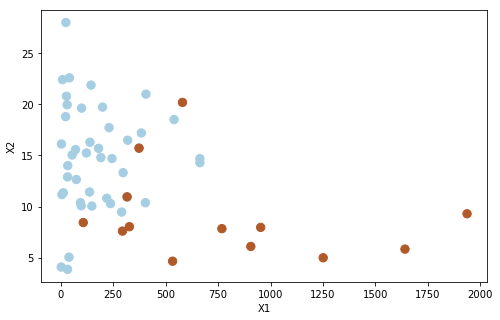

/Users/dejiatang/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


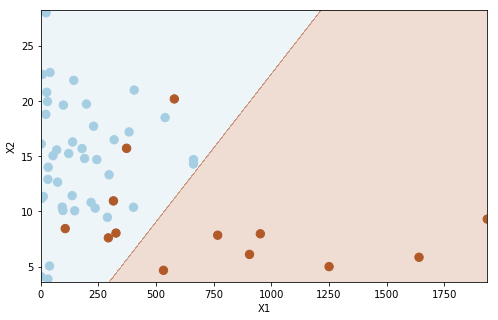

Number of support vectors:  17
confusion matrix: 
    0  1
0  29  4
1   0  6


In [9]:
svm_classification(landmarks, -14.29, -4.76, -0.79, 0)